In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the paths for the dataset
local_zip = 'drive/MyDrive/dataset/sampah.zip'
extracted_path = 'content/sampah/'

# Unzip the dataset
import zipfile
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Define train, val, test directories
train_dir = 'content/input/train'
val_dir = 'content/input/val'
test_dir = 'content/input/test'

# Create directories for training, validation, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data into train, val, test
def split_data(source_dir, train_dir, val_dir, test_dir, split_size=(0.8, 0.1, 0.1)):
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
            np.random.shuffle(files)
            train_size = int(len(files) * split_size[0])
            val_size = int(len(files) * split_size[1])
            train_files = files[:train_size]
            val_files = files[train_size:train_size + val_size]
            test_files = files[train_size + val_size:]

            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(val_dir, category), exist_ok=True)
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)

            for file in train_files:
                shutil.copy(os.path.join(category_path, file), os.path.join(train_dir, category, file))
            for file in val_files:
                shutil.copy(os.path.join(category_path, file), os.path.join(val_dir, category, file))
            for file in test_files:
                shutil.copy(os.path.join(category_path, file), os.path.join(test_dir, category, file))

# Split the data
split_data(extracted_path, train_dir, val_dir, test_dir)

# Now you have train, val, and test directories under content/input


Mounted at /content/drive


In [3]:
# Create ImageDataGenerator instances
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    fill_mode='nearest'
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Create training, validation, and test batches
training_batches = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle=True
)

validation_batches = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle=True
)

test_batches = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle=True  # Shuffle enabled for test set
)

Found 14411 images belonging to 12 classes.
Found 1797 images belonging to 12 classes.
Found 1811 images belonging to 12 classes.


In [4]:
# Load the MobileNet model
mobile = tf.keras.applications.mobilenet.MobileNet()

# Modify the model
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
x = mobile.layers[-5].output
x = Flatten()(x)
x = Dropout(0.1)(x)
output = Dense(12, activation='softmax')(x)

from tensorflow.keras.models import Model
model = Model(inputs=mobile.input, outputs=output)

# Freeze all the layers except the last 23 layers
for layer in model.layers[:-23]:
    layer.trainable = False

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

17225924/17225924 [==============================] - 2s 0us/step


In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

history = model.fit(x=training_batches,
                    validation_data=validation_batches,
                    callbacks=early_stopping,
                    epochs=10
                    )

Epoch 1/10
57/57 [==============================] - 217s 4s/step - loss: 0.8203 - accuracy: 0.7457 - val_loss: 1.1484 - val_accuracy: 0.7129
Epoch 2/10
57/57 [==============================] - 203s 4s/step - loss: 0.3211 - accuracy: 0.8995 - val_loss: 0.5950 - val_accuracy: 0.8158
Epoch 3/10
57/57 [==============================] - 202s 4s/step - loss: 0.2426 - accuracy: 0.9248 - val_loss: 0.3337 - val_accuracy: 0.8920
Epoch 4/10
57/57 [==============================] - 199s 3s/step - loss: 0.1921 - accuracy: 0.9421 - val_loss: 0.2440 - val_accuracy: 0.9215
Epoch 5/10
57/57 [==============================] - 203s 4s/step - loss: 0.1632 - accuracy: 0.9489 - val_loss: 0.1932 - val_accuracy: 0.9360
Epoch 6/10
57/57 [==============================] - 208s 4s/step - loss: 0.1448 - accuracy: 0.9554 - val_loss: 0.1782 - val_accuracy: 0.9416
Epoch 7/10
57/57 [==============================] - 202s 4s/step - loss: 0.1242 - accuracy: 0.9620 - val_loss: 0.1838 - val_accuracy: 0.9410
Epoch 8/10
57

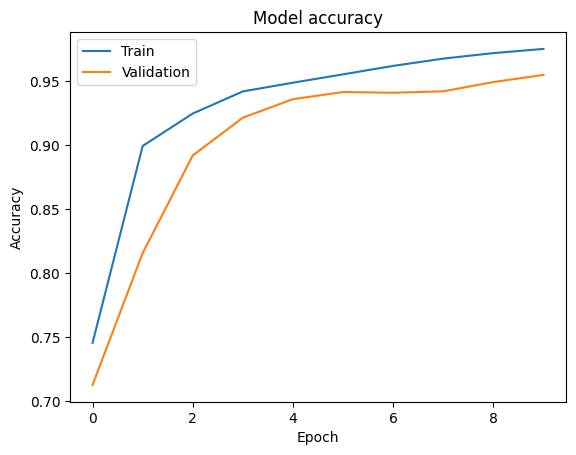

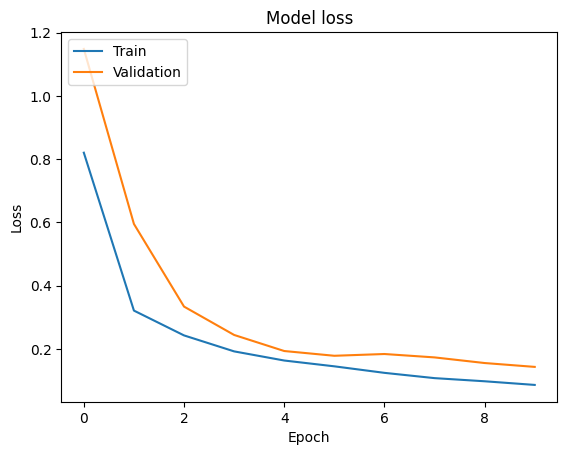

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

8/8 [==============================] - 6s 709ms/step - loss: 0.1243 - accuracy: 0.9625
Test accuracy: 96.25%


8/8 [==============================] - 2s 31ms/step


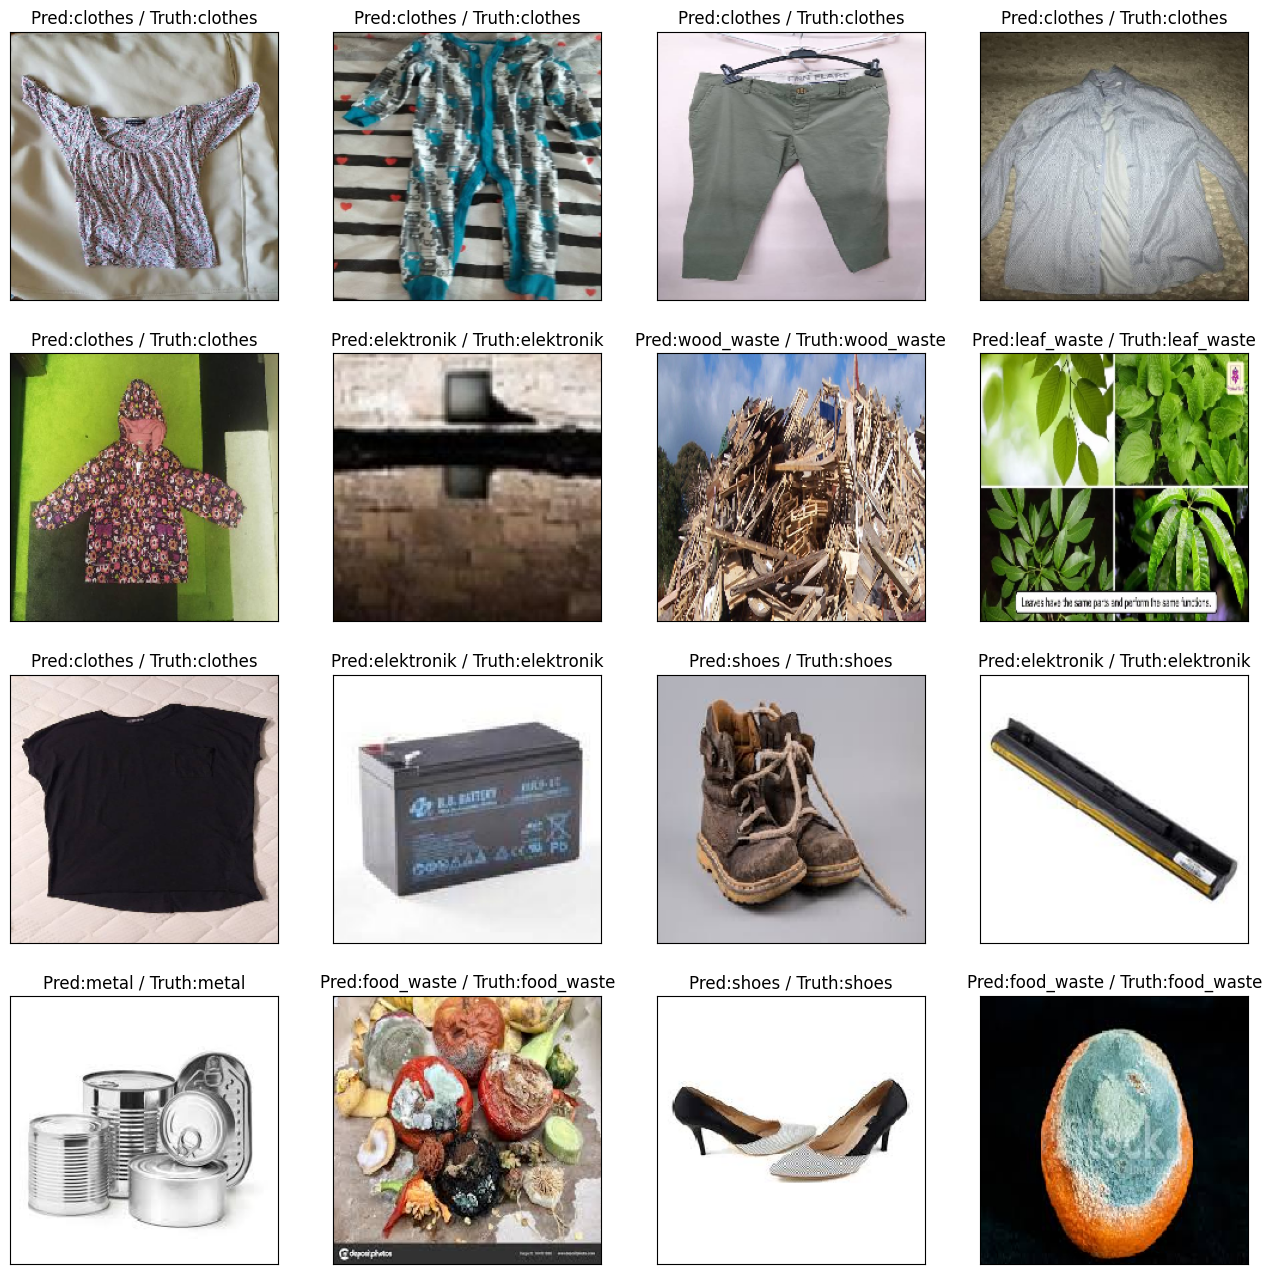

In [8]:
# Plot predictions on test data
test_x, test_y = test_batches.__getitem__(1)
preds = model.predict(test_x)

labels = (training_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Pred:%s / Truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [9]:
model_save_path = "/content/drive/MyDrive/dataset/sampah.h5"
saved_model_export_path = "/content/drive/MyDrive/saved_model"

model.save(model_save_path)
tf.saved_model.save(model, saved_model_export_path)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_export_path)
tflite_model = converter.convert()

tflite_model_save_path = "/content/drive/MyDrive/dataset/model.tflite"
with open(tflite_model_save_path, "wb") as f:
    f.write(tflite_model)

print(f"Model disimpan dalam format .h5 di: {model_save_path}")
print(f"Model diekspor ke format SavedModel di: {saved_model_export_path}")
print(f"Model TensorFlow Lite disimpan di: {tflite_model_save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model disimpan dalam format .h5 di: /content/drive/MyDrive/dataset/sampah.h5
Model diekspor ke format SavedModel di: /content/drive/MyDrive/saved_model
Model TensorFlow Lite disimpan di: /content/drive/MyDrive/dataset/model.tflite


Saving pxfuel.com_-961x806.jpg to pxfuel.com_-961x806.jpg
1/1 [==============================] - 0s 24ms/step


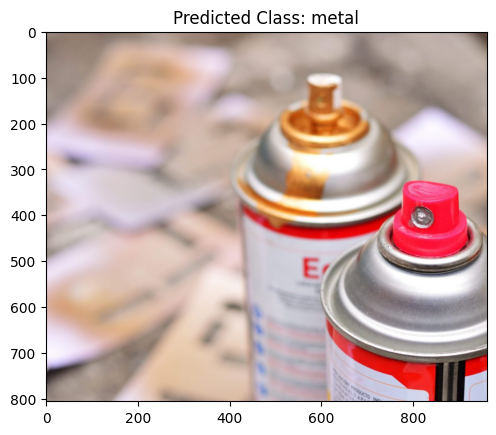

Predicted probabilities: [[5.3890829e-04 1.3621319e-02 2.8223142e-02 1.5089265e-02 4.2095589e-03
  7.8129437e-04 8.4336114e-01 1.7724215e-03 7.9160020e-02 5.8947137e-04
  2.9639960e-03 9.6893935e-03]]


In [48]:
from google.colab import files
from tensorflow.keras.preprocessing import image
# Function to preprocess the uploaded image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Function to predict the class of the image
def predict_image_class(model, img_array):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0], predictions

# Upload the image
uploaded = files.upload()

for img_path in uploaded.keys():
    img_array = preprocess_image(img_path)
    predicted_class, predictions = predict_image_class(model, img_array)

    # Mapping class indices to class labels
    labels = (training_batches.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted Class: {labels[predicted_class]}")
    plt.show()

    print(f"Predicted probabilities: {predictions}")